In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
mnist = keras.datasets.mnist
mnist

<module 'keras.api._v2.keras.datasets.mnist' from 'c:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\keras\\api\\_v2\\keras\\datasets\\mnist\\__init__.py'>

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [8]:
y_train.shape

(60000,)

In [6]:
x_train[0][1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

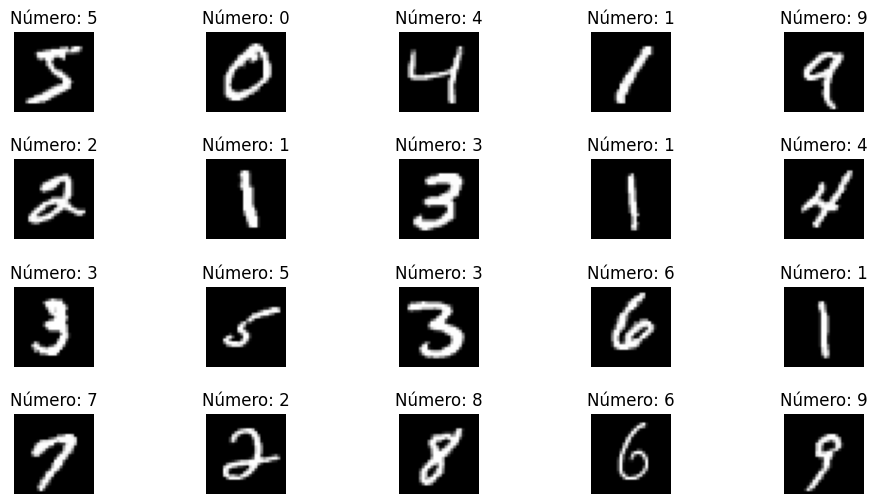

In [4]:
fig, axs = plt.subplots(4,5, figsize=(12,6)) #4 é o número de linhas e 5 o número de colunas

for i, ax in enumerate(axs.flat):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Número: {y_train[i]}")
    ax.axis("off")

fig.subplots_adjust(hspace=0.60)    
plt.show()

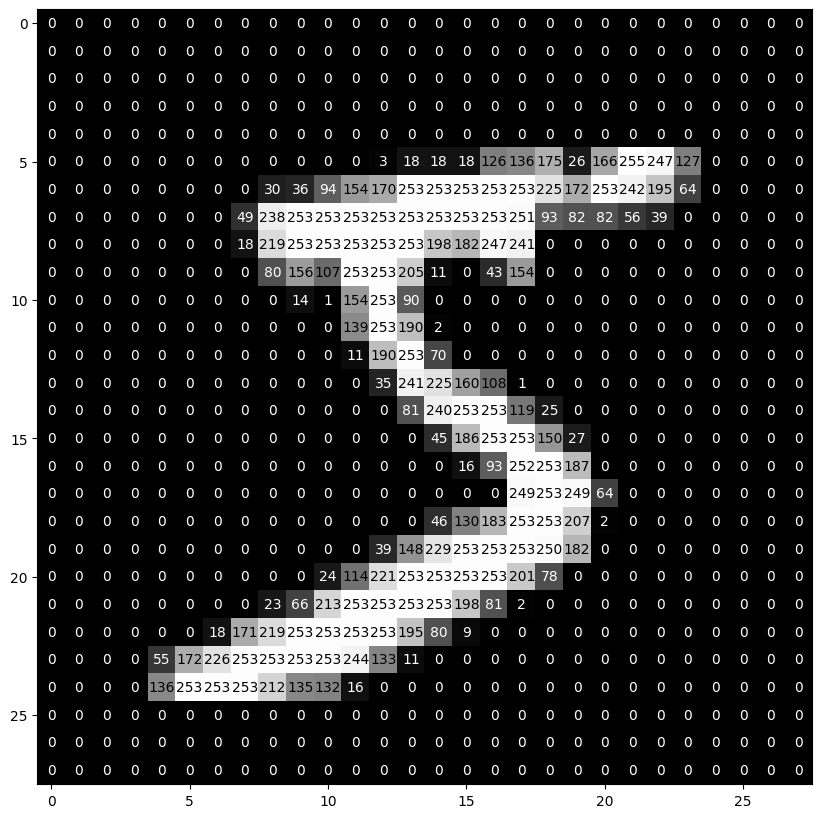

In [5]:
fig, ax = plt.subplots(figsize=(10, 12))

ax.imshow(x_train[0], cmap="gray")

for linha in range(28):
    for coluna in range(28):
        valor_cor = x_train[0][linha][coluna]
        ax.annotate(
            str(valor_cor),
            xy=(coluna,linha),
            color = "black" if valor_cor > 100 else "white",
            horizontalalignment = "center",
            verticalalignment = "center"
        )

plt.show()


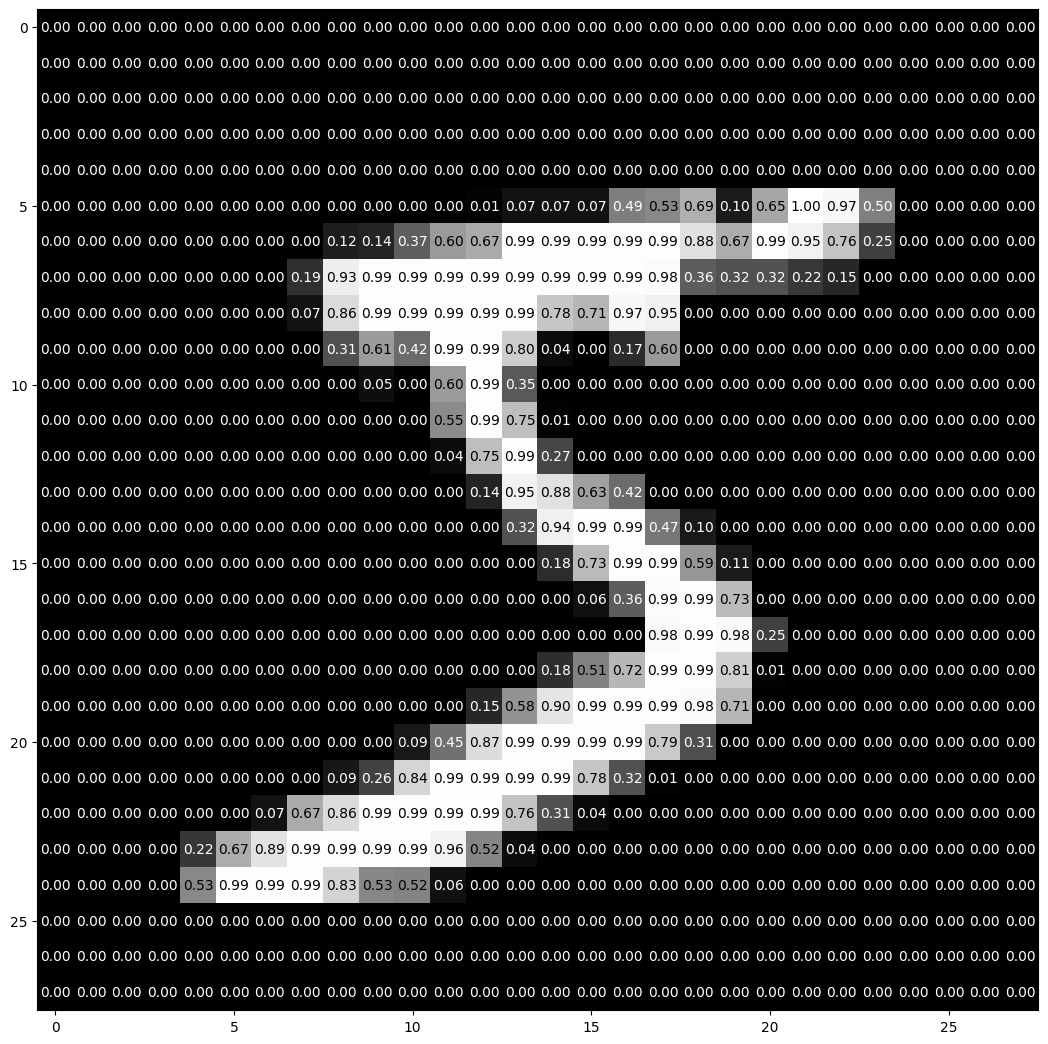

In [6]:
fig, ax = plt.subplots(figsize=(13, 13))

ax.imshow(x_train[0]/255, cmap="gray")

for linha in range(28):
    for coluna in range(28):
        valor_cor = x_train[0][linha][coluna]/255
        ax.annotate(
            f"{valor_cor:.2f}",
            xy=(coluna,linha),
            color = "black" if valor_cor > 0.5 else "white",
            horizontalalignment = "center",
            verticalalignment = "center"
        )

plt.show()


In [9]:
x_train.shape

(60000, 28, 28)

Criação do modelo

In [7]:
def model_builder(hp):
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    model.add(keras.layers.Rescaling(scale=1./255))
    
    model.add(keras.layers.RandomRotation(0.1))
    model.add(keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1))
    model.add(keras.layers.RandomZoom(0.1))
    
    model.add(keras.layers.Conv2D(
        hp.Int("conv_1_filters",  min_value=16, max_value=64, step=2, sampling="log"), 
        (3, 3),  
        activation="relu"))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Conv2D(
        hp.Int("conv_2_filters",  min_value=32, max_value=128, step=2, sampling="log"), 
        (3, 3),  
        activation="relu"))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation="softmax"))


    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1E-2, 1E-3, 1E-4]))
    loss = keras.losses.SparseCategoricalCrossentropy()
    metric = keras.metrics.SparseCategoricalAccuracy()
    
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

Compilar o modelo Keras

In [33]:
import keras_tuner as kt

In [34]:
tuner = kt.Hyperband(
    model_builder,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    directory = "tuner",
    project_name= "mnist"

)

Fit do modelo

In [35]:
early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    min_delta=1E-4,
)

tuner.search(
    x_train,
    y_train,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
)

FailedPreconditionError: tuner\mnist is not a directory

Evaluate do modelo

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9884


[0.038461945950984955, 0.9883999824523926]

Predict do modelo

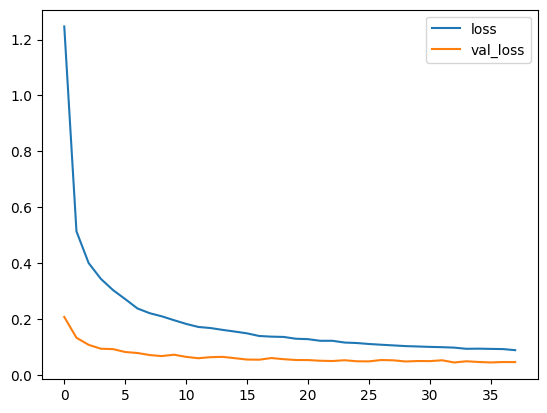

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

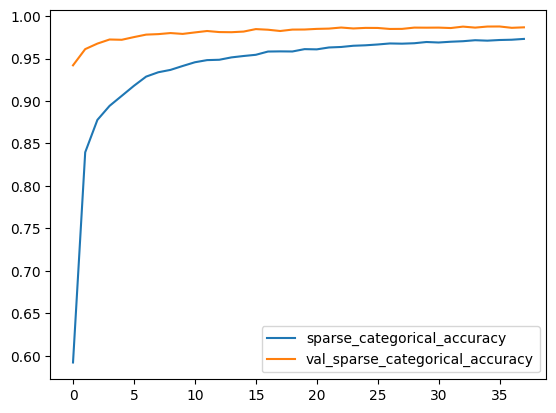

In [ ]:
plt.plot(history.history["sparse_categorical_accuracy"], label="sparse_categorical_accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="val_sparse_categorical_accuracy")
plt.legend()
plt.show()

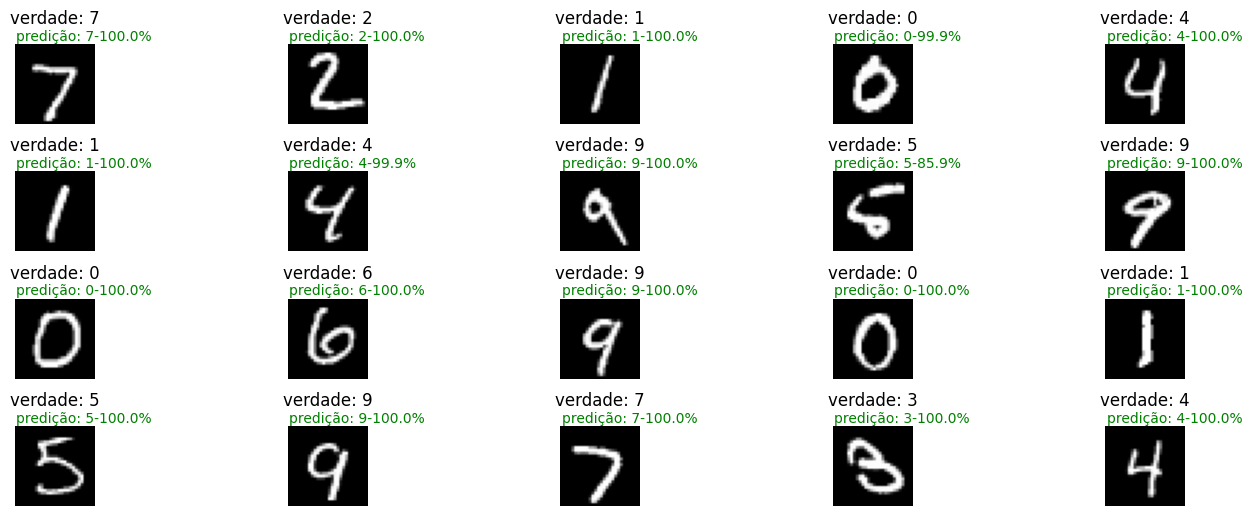

In [ ]:
fig, axs = plt.subplots(4,5, figsize=(17,6)) #4 é o número de linhas e 5 o número de colunas

for i, ax in enumerate(axs.flat):
    ax.imshow(x_test[i], cmap='gray')
    pred = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0]
    ax.set_title(f"verdade: {y_test[i]}", pad=15) #pad é para espaçar
    ax.axis("off")
    ax.text(
        0,
        -2,
        f"predição: {pred.argmax()}-{pred.max():.1%}",
        color="green" if pred.argmax() == y_test[i] else "red"
    )
fig.subplots_adjust(hspace=0.60) 
plt.show()

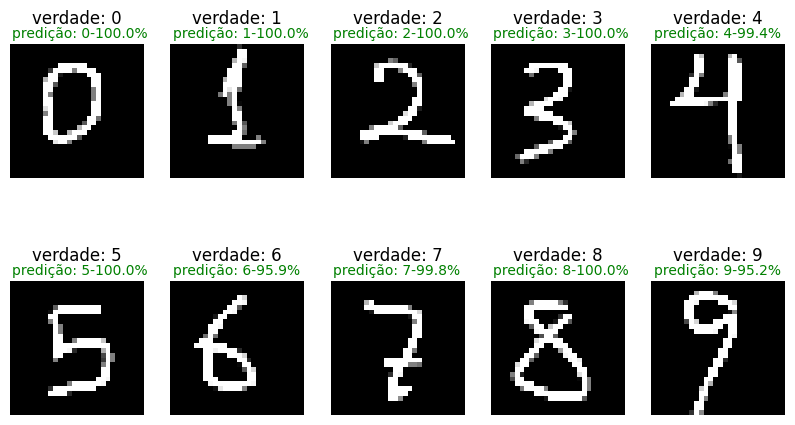

In [ ]:
from pathlib import Path

test_images_dir = Path(r"C:\Users\User\Desktop\Ciência de Dados\Curso Hashtag\Deep learning\test_images")

fig, axs = plt.subplots(2, 5, figsize=(10,5))

all_pred = {}

for i, (img, ax) in enumerate(zip(sorted(test_images_dir.glob("*.png")), axs.flat)):
    name = img.name.split(".")[0] #O [0] é por conta do batch que veio a partir do expand.dims
    #
    img = keras.preprocessing.image.load_img(
        img, target_size=(28,28), color_mode="grayscale"
    )
    #
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = 255 - img_array
    img_array = tf.expand_dims(img_array, 0)
    
    pred = model.predict(img_array, verbose=0)
    all_pred[name] = pred
    
    ax.imshow(img_array[0], cmap='gray')
    ax.set_title(f"verdade: {name}", pad=15) #pad é para espaçar
    ax.axis("off")
    ax.text(
        0,
        -2,
        f"predição: {pred.argmax()}-{pred.max():.1%}",
        color="green" if str(pred.argmax()) == name else "red"
    )
fig.subplots_adjust(hspace=0.60) 
plt.show()


In [ ]:
x = all_pred["7"]
x

array([[1.7924165e-09, 9.2522959e-07, 2.0407063e-03, 6.6626402e-05,
        6.5893211e-13, 2.7732197e-11, 1.0477914e-12, 9.9789149e-01,
        2.0602531e-07, 2.9785821e-10]], dtype=float32)